In [225]:
# !pip install hazm parsivar

In [44]:
# pip install nltk

In [45]:
# !pip install catboost

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import missingno as msgn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import hazm
import nltk
from hazm import word_tokenize
from nltk import bigrams
from parsivar import Tokenizer, FindStems
from hazm.utils import stopwords_list
from gensim.models import Word2Vec
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import svm
from imblearn.over_sampling import SMOTE
import catboost
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import multiprocessing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1- Loading data

in this section, we are going to load and peform EDA steps on the dataset to gain insights about what we are dealing with.

In [47]:
data = pd.read_excel('/content/train_data.xlsx', header=None)

In [48]:
data.head()

,0,1
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4924 entries, 0 to 4923
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       4924 non-null   object
 1   1       4924 non-null   object
dtypes: object(2)
memory usage: 77.1+ KB


<Axes: >

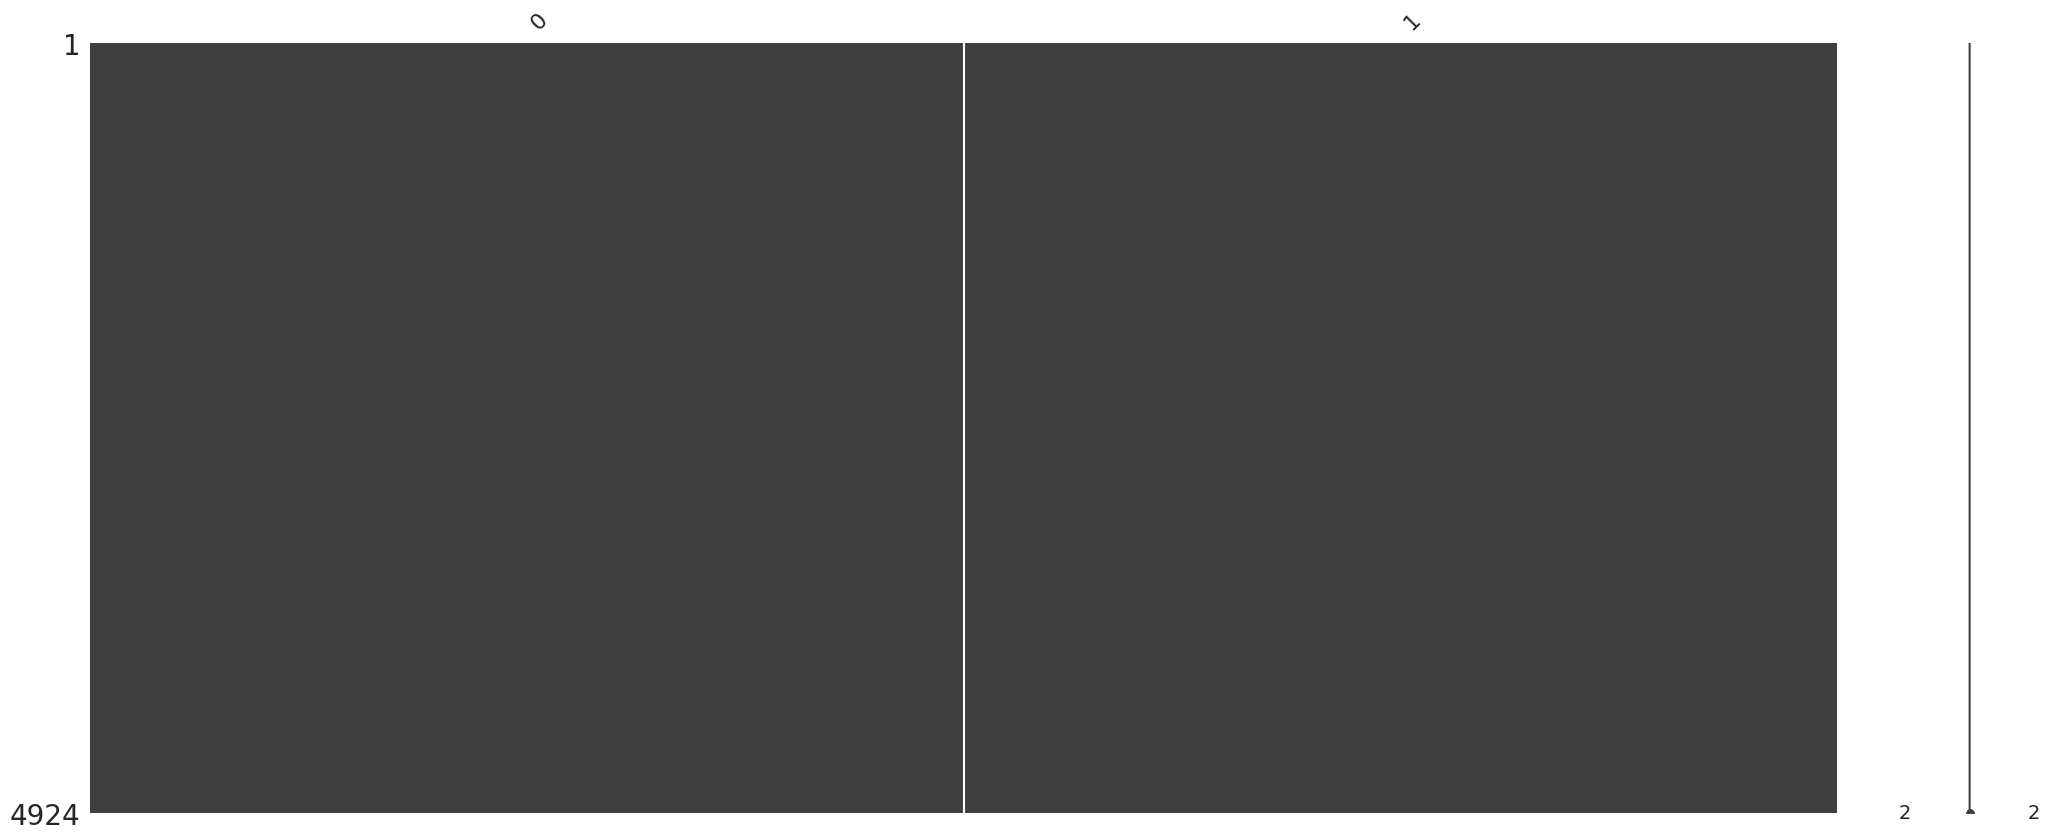

In [50]:
msgn.matrix(data)

# 2- Data preprocessing

In [51]:
X, y = data[0], data[1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

In [52]:
def count_punctuation(text):
    punctuation_counts = {p: text.count(p) for p in string.punctuation}
    return punctuation_counts

punctuation_features_train = [count_punctuation(text) for text in x_train]
punctuation_features_test = [count_punctuation(text) for text in x_test]

In [53]:
df_puncs_train = pd.DataFrame(punctuation_features_train, index=x_train.index)
df_puncs_test = pd.DataFrame(punctuation_features_test, index=x_test.index)

In [54]:
def remove_non_persian(text):
    # Persian alphabet characters including Persian numerals and punctuation
    persian_alphabet = (
        'ا' 'ب' 'پ' 'ت' 'ث' 'ج' 'چ' 'ح' 'خ' 'د' 'ذ' 'ر' 'ز' 'ژ' 'س' 'ش'
        'ص' 'ض' 'ط' 'ظ' 'ع' 'غ' 'ف' 'ق' 'ک' 'گ' 'ل' 'م' 'ن' 'و' 'ه' 'ی'
        'ء' 'آ' 'ئ' 'ؤ' 'ى' 'ۀ' ' '
    )

    punc = ('!' '?' '؟' '.')
    # Persian numerals
    persian_numerals = '۰۱۲۳۴۵۶۷۸۹'

    # Combine Persian alphabet and numerals
    persian_characters = persian_alphabet + persian_numerals + punc

    # Create a regex pattern to match any character not in the Persian characters set
    pattern = f'[^{persian_characters}]'

    # Use re.sub() to replace all non-Persian characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

In [55]:
normalizer = hazm.Normalizer()

def preprocess_text_1(text):

    text = normalizer.normalize(text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)

    # convert arabic alphabet to persian
    text = re.sub(pattern = 'ك' , repl = 'ک', string = text)
    text = re.sub(pattern = 'ي' , repl = 'ی', string = text)
    text = re.sub(pattern = 'ى' ,repl = 'ی', string = text)
    text = re.sub(pattern = 'ئ', repl = 'ی', string = text)
    text = re.sub(pattern = 'إ',repl =  'ا', string = text)
    text = re.sub(pattern = 'أ' , repl = 'ا', string = text)
    text = re.sub(pattern = 'ؤ' , repl = 'و', string = text)
    text = re.sub(pattern = 'آ' , repl = 'ا', string = text)

    return text

def text_rokenizer(text):
    tokens = word_tokenize(text)
    return tokens


x_train = x_train.apply(preprocess_text_1)
x_test = x_test.apply(preprocess_text_1)

x_train = x_train.apply(remove_non_persian)
x_test = x_test.apply(remove_non_persian)

In [56]:
space_types = x_train.str.extractall(r'(\s)').groupby(level=0).nunique()

if space_types.max().item() == 1:
    print("One Type of Space.")
else:
    print("Multiple Types of Spaces.")

One Type of Space.


In [57]:
tokenizer = Tokenizer()
stopwords = stopwords_list()

def tokenize(text):
    return tokenizer.tokenize_words(text)

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

def preprocess_text(text, use_stemming=False):
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

def preprocess_series(text_series, use_stemming=False):
    return text_series.apply(lambda x: preprocess_text(x, use_stemming))

x_train = preprocess_series(x_train)
print('Preprocessing for train done.')

x_test = preprocess_series(x_test)
print('Preprocessing for test done.')

Preprocessing for train done.
Preprocessing for test done.


# Fast text hazm

In [ ]:
data[1].unique()

array(['SAD', 'OTHER', 'HAPPY', 'ANGRY', 'FEAR'], dtype=object)

In [ ]:
maping = {'SAD' : 0, 'OTHER' : 1, 'HAPPY': 2, 'ANGRY': 3, 'FEAR': 4}
y_train = y_train.map(maping)
y_test = y_test.map(maping)

<BarContainer object of 5 artists>

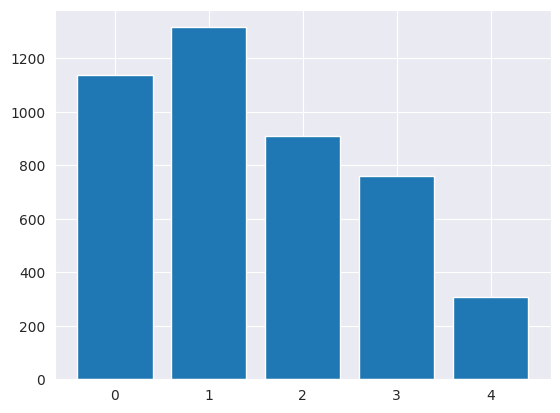

In [ ]:
plt.bar(x = y_train.unique(), height=y_train.value_counts())

In [24]:
from hazm import WordEmbedding

In [25]:
embedding = WordEmbedding(model_type='fasttext')

In [26]:
# !pip install mega.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.3.0
    Uninstalling tenacity-8.3.0:
      Successfully uninstalled tenacity-8.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotly 5.15.0 requires tenacity>=6.2.0, but you have tenacity 5.1.5 which is incompatible.


In [27]:
# from mega import Mega

# mega = Mega()

# url = 'https://mega.nz/file/GqZUlbpS#XRYP5FHbPK2LnLZ8IExrhrw3ZQ-jclNSVCz59uEhrxY'

# file = mega.download_url(url)

# file_path = file.name
# print(f"Downloaded file: {file_path}")

Downloaded file: fasttext_model.zip


In [28]:
# import zipfile
# import os

# zip_file_path = '/content/fasttext_model.zip'

# # Specify the directory to extract to
# extract_dir = '/content/extracted/'

# # Create a ZipFile object
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents of zip file into the specified directory
#     zip_ref.extractall(extract_dir)

# print(f"Files extracted to {extract_dir}")

Files extracted to /content/extracted/


In [29]:
embedding.load_model('/content/extracted/fasttext_skipgram_300.bin')

In [58]:
def get_embedding_vector(words):
    vectors = [embedding[word] for word in words]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding.vector_size)

In [204]:
tokenized_tweets_train = [word_tokenize(tweet) for tweet in x_train]
tokenized_tweets_test = [word_tokenize(tweet) for tweet in x_test]

df_train = np.array([get_embedding_vector(tweet) for tweet in tokenized_tweets_train])
df_test = np.array([get_embedding_vector(tweet) for tweet in tokenized_tweets_test])

In [41]:
clf = RandomForestClassifier(random_state=42)
clf.fit(df_train, y_train)

# Predict and evaluate
y_pred = clf.predict(df_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.5862457722660653


# Gensim doc2vec

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from imblearn.over_sampling import KMeansSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Custom transformer for Doc2Vec
class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, min_count=5, epochs=100):
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs

    def fit(self, X, y=None):
        tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(doc.split()) for doc in X])

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

doc2vec_transformer = Doc2VecTransformer()

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', tfidf_vectorizer),
        ('doc2vec', doc2vec_transformer)
    ])),
    ('clf', svm.SVC(kernel = 'poly', degree = 4, random_state = 42))
])


# Train the model
pipeline.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(ngram_range=(1,
                                                                              2))),
                                                ('doc2vec',
                                                 Doc2VecTransformer())])),
                ('clf', SVC(degree=4, kernel='poly', random_state=42))])

In [ ]:
# Predict and evaluate
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       ANGRY       0.33      0.17      0.22       101
        FEAR       0.12      0.18      0.14        34
       HAPPY       0.40      0.80      0.54       146
       OTHER       0.28      0.10      0.15       127
         SAD       0.30      0.19      0.23        85

    accuracy                           0.34       493
   macro avg       0.29      0.29      0.26       493
weighted avg       0.32      0.34      0.29       493



# Customise word2vec

In [ ]:
# Custom transformer for Word2Vec
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, min_count=5, epochs=150, window = 6, sg = 1):
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs
        self.window = window
        self.sg = sg

    def fit(self, X, y=None):
        sentences = [doc.split() for doc in X]

        self.model = Word2Vec(
            sentences,
            vector_size=self.vector_size,
            min_count=self.min_count,
            epochs=self.epochs,
            sg= self.sg,
            window = self.window)
        return self

    def transform(self, X):
        sentences = [doc.split() for doc in X]
        return np.array([np.mean([self.model.wv[word] for word in sentence if word in self.model.wv] or [np.zeros(self.vector_size)], axis=0) for sentence in sentences])

word2vec_transformer = Word2VecTransformer()

# Define the pipeline
pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(ngram_range=(1,4),max_features=500)),
        ('word2vec', word2vec_transformer)
    ])),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(x_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       ANGRY       0.54      0.45      0.49       101
        FEAR       0.40      0.50      0.45        34
       HAPPY       0.79      0.73      0.75       146
       OTHER       0.52      0.56      0.54       127
         SAD       0.51      0.56      0.53        85

    accuracy                           0.58       493
   macro avg       0.55      0.56      0.55       493
weighted avg       0.59      0.58      0.58       493



In [ ]:
# Predict and evaluate
y_pred = pipeline.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       ANGRY       0.99      0.98      0.99       911
        FEAR       0.99      1.00      1.00       308
       HAPPY       0.99      0.98      0.99      1316
       OTHER       0.96      0.98      0.97      1136
         SAD       0.97      0.97      0.97       760

    accuracy                           0.98      4431
   macro avg       0.98      0.98      0.98      4431
weighted avg       0.98      0.98      0.98      4431



its a simple pipeline to test if the tf-idf using chi2 to feature selection is good.

- I also tested the combination of the doc2vec and tf-idf, word2vec and tf-idf and other variants of word2vec feature sparsing like `chi2`. overall result were the same as before.
- at last, best result was for this combination:
- tf-idf with ngram_range = (1,2) and max_features = 500
- word2vec with defined parameters.
- SMOTE for balancing.
- RandomForrest for classifier.
- accuracy = 60%

but we did a great improvement in overall result!! we started from 43% with raw tf-idf and 41% with raw word2vec.

## TF-IDF and word2vec

I tried hezarai embedding tools for word2vec features, it didnt perform well on the data, so i continued with the gensim word2vec model.

In [185]:
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(x_train)
test_tfidf = tfidf_vectorizer.transform(x_test)

In [186]:
train_tfidf.toarray().shape

(4431, 9384)

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
sentences = [sentence.split() for sentence in x_train]

w2v_model = Word2Vec(
    sentences=sentences,
    epochs = 150,
    vector_size=300,  # You can choose the size of the word vectors
    window=7,        # The maximum distance between the current and predicted word within a sentence
    sg=1,            # Use skip-gram; if sg=0, CBOW is used
    min_count=5,     # Ignores all words with total frequency lower than this
    workers=cores        # Use these many worker threads to train the model
)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

# tfidf = TfidfVectorizer()
# tfidf.fit(x_train)  # 'corpus' is a list of sentences

# def tfidf_weighted_vectorize(sentence):
#     words = sentence.split()
#     word_vecs = []
#     weights = []
#     for word in words:
#         if word in w2v_model.wv:
#             word_vecs.append(w2v_model.wv[word])
#             weights.append(tfidf.vocabulary_.get(word, 0))
#     if not word_vecs:
#         return np.zeros(300)
#     word_vecs = np.array(word_vecs)
#     weights = np.array(weights)
#     return np.average(word_vecs, axis=0, weights=weights)

x_train_w2v = np.array([vectorize(sentence) for sentence in x_train])
x_test_w2v = np.array([vectorize(sentence) for sentence in x_test])
# x_train_w2v = np.array([tfidf_weighted_vectorize(sentence) for sentence in x_train])
# x_test_w2v = np.array([tfidf_weighted_vectorize(sentence) for sentence in x_test])

## visualize the word2vec result

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
tsnescatterplot(w2v_model, 'ایران', ['مرگ', 'زندگی', 'بد', 'هواپیما', 'کتاب', 'فشار', 'درد', 'مهسا'])

we also train a model for tuning the vectorizer model to find best parameters, the best result was for current set of parameters.

In [ ]:
# temp = ''
# for text in x_train:
#   temp += '\n' + text
# with open('big_string.txt', 'w') as f:
#   f.write(temp)

In [ ]:
df_train = np.concatenate((x_train_w2v, train_tfidf.toarray()), axis = 1)
df_test = np.concatenate((x_test_w2v, test_tfidf.toarray()), axis = 1)

In [ ]:
df_train = pd.DataFrame(df_train, columns = np.arange(df_train.shape[1]), index = x_train.index)
df_test = pd.DataFrame(df_test, columns = np.arange(df_test.shape[1]), index = x_test.index)

In [ ]:
df_train.columns = df_train.columns.astype(str)
df_test.columns = df_test.columns.astype(str)

## PCA on the TF-IDF and w2v features to reduce the dimensions

In [ ]:
# Initialize PCA, let's assume we want to reduce to 2 components for visualization
pca = PCA(n_components=3)
# Fit and transform the TF-IDF and w2v features
pca_features = pca.fit_transform(df_train)
pca_features_test = pca.transform(df_test)

In [ ]:
df_pca_train = pd.DataFrame(pca_features, columns = ['PC1', 'PC2', 'PC3'], index = x_train.index)
df_pca_test = pd.DataFrame(pca_features_test, columns = ['PC1', 'PC2', 'PC3'], index = x_test.index)

In [ ]:
df_train = pd.concat([df_train, df_pca_train], axis = 1)
df_test = pd.concat([df_test, df_pca_test], axis = 1)

In [ ]:
df_train.columns = df_train.columns.astype(str)
df_test.columns = df_test.columns.astype(str)

### Encode target column

it seems to be a little imbalance distribution over classes, we may need to balance them later on.

# 3- Model training

In [62]:
def classification_results(y_pred, y_true, phase, method = ''):
    print(f"{method} Classification Report {phase}:")
    print(classification_report(y_true, y_pred))

In [63]:
# Visualization
def plot_classification_report(y_true, y_pred, title = ''):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
    plt.title(title)
    plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators= 100, random_state=42)
# rf.fit(df_train, y_train)
rf.fit(x_train_w2v, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# classification_results(y_true=y_train, y_pred=rf.predict(df_train), phase='Train')
classification_results(y_true=y_train, y_pred=rf.predict(x_train_w2v), phase='Train')

 Classification Report Train:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       760
           1       0.97      0.98      0.98      1136
           2       0.97      0.99      0.98      1316
           3       0.99      0.98      0.99       911
           4       1.00      0.99      1.00       308

    accuracy                           0.98      4431
   macro avg       0.98      0.98      0.98      4431
weighted avg       0.98      0.98      0.98      4431



In [ ]:
# y_pred = rf.predict(df_test)
y_pred = rf.predict(x_test_w2v)

In [ ]:
classification_results(y_true=y_test, y_pred=y_pred, phase='Test')

 Classification Report Test:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42        85
           1       0.47      0.73      0.57       127
           2       0.79      0.80      0.79       146
           3       0.62      0.40      0.48       101
           4       0.60      0.18      0.27        34

    accuracy                           0.58       493
   macro avg       0.59      0.50      0.51       493
weighted avg       0.60      0.58      0.57       493



In [ ]:
rf = RandomForestClassifier(n_estimators= 100, random_state=42)
rf.fit(df_train, y_train)
y_pred = rf.predict(df_test)
# rf.fit(x_train_w2v, y_train)
print(accuracy_score(y_test, y_pred))

0.5679513184584178


## Test SVM on w2v features

In [178]:
svc = svm.SVC(kernel = 'rbf', degree = 1, C= 0.8)
svc.fit(df_train, y_train)

SVC(C=0.8, degree=1)

In [179]:
classification_results(y_true=y_train, y_pred=svc.predict(df_train), phase='Train')

 Classification Report Train:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       760
           1       0.58      0.81      0.68      1136
           2       0.92      0.78      0.85      1316
           3       0.77      0.62      0.68       911
           4       0.77      0.42      0.54       308

    accuracy                           0.72      4431
   macro avg       0.74      0.67      0.69      4431
weighted avg       0.75      0.72      0.72      4431



In [180]:
classification_results(y_true=y_test, y_pred=svc.predict(df_test), phase='Test')

 Classification Report Test:
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        85
           1       0.53      0.77      0.63       127
           2       0.92      0.80      0.86       146
           3       0.66      0.50      0.57       101
           4       0.52      0.32      0.40        34

    accuracy                           0.67       493
   macro avg       0.65      0.61      0.62       493
weighted avg       0.69      0.67      0.67       493



In [181]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
svm.SVC()

In [184]:
param_grid = {
    'kernel': ['rbf', 'poly', 'linear'],
    'degree': [1, 2, 3, 4]
}
svc = svm.SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(df_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print("Mean: {:.2f}, Std: {:.2f} with: {}".format(mean, std, params))

Best parameters found:  {'degree': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.64
Mean: 0.64, Std: 0.02 with: {'degree': 1, 'kernel': 'rbf'}
Mean: 0.62, Std: 0.02 with: {'degree': 1, 'kernel': 'poly'}
Mean: 0.62, Std: 0.01 with: {'degree': 1, 'kernel': 'linear'}
Mean: 0.64, Std: 0.02 with: {'degree': 2, 'kernel': 'rbf'}
Mean: 0.63, Std: 0.01 with: {'degree': 2, 'kernel': 'poly'}
Mean: 0.62, Std: 0.01 with: {'degree': 2, 'kernel': 'linear'}
Mean: 0.64, Std: 0.02 with: {'degree': 3, 'kernel': 'rbf'}
Mean: 0.63, Std: 0.01 with: {'degree': 3, 'kernel': 'poly'}
Mean: 0.62, Std: 0.01 with: {'degree': 3, 'kernel': 'linear'}
Mean: 0.64, Std: 0.02 with: {'degree': 4, 'kernel': 'rbf'}
Mean: 0.63, Std: 0.01 with: {'degree': 4, 'kernel': 'poly'}
Mean: 0.62, Std: 0.01 with: {'degree': 4, 'kernel': 'linear'}


the result of CV shows that the accuracy of our model is significant! sinse the 0.64 +- 0.02 is close to the test result.

# KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)

In [67]:
neigh.fit(df_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [68]:
y_pred = neigh.predict(df_test)
print(accuracy_score(y_test, y_pred))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f908b8f8ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory


0.5963488843813387


## Analyze the result

- the model didnt perform well on the dataset, its just simply overfitted. in next step, we are going to apply some regularization techniques like `Tree pruning` and hyperparameter tuning on the model to achive better result.

**other expriences**:
- I also tried to train a model with only TF-IDF features and only word2vec features individually, but in these cases, the result for each part was less than the combination of both features, so let us continue with combination of both tf-idf and w2v feature in our future experiences.

- Due to the classification result report(percision recall and f1-score of each classes), the best performance of the model was on `HAPPY` label, which means the data is well represented to model to recognize happy emotions, it could dbe becuase of the frequency of happy words in the texts are more logical to term of tf-idf features.
so the data is challenging for classical machine learning algorithms. I may need to use Transformers at last(after we tested other classical models and simple MLP)

- I also tested the `skip-grams` for word tokenizing to see if its works better with data, it improves the result but it still not satisfying!

- At last, i gave up using TF-IDF features since it doesnt effect on the result, so i focus on train and tune a good word2vec model and it worked!

- and also i change normal train-test-split to stratified vesion, which does not effected the result, but since the data was imbalance, i think its more significant!

- Also the balancing texhnique SMOTE didint improve overall accuracy, but it improves the result in minority class.

- I also tried a different variation of word2vec, instead of simple average on word2vec result for each word, i add a weighted average by its TF-IDF. it didnt improved the result.

since now, the best result is for:

polynomial SVM with degree = 4 ==> accuracy = 60%

for the last card, i try pre-trained word2vec model `fasttext` from hazm. and the result was as follows:
- SVM with rbf kernel --> **67%**, and catboost --> accuracy = **65%**


i did train our word2vec model on 100 epochs with new wet of parameters and it leads to a significant improve in general result in our models, so the main important features for the model is word2vec, than TF-IDF which is makes sense.

also i removed some of unnecessary steps in the preprocessing step, which leads to better embeddings.

the main challenge in this task is Data, the twits are in this dataset are in very bad format, there are lots of words and phrases which doesnt make sense in persian language but used in the text and also there is lots of sentences which contains english but with persian alphabet like ('ارلی برد کچز د ورم') which doesnt make sense!!

so i remove the words with the frequencies less than 4 to avoid these sentences and words.

# 4- balancing

In [120]:
smote = SMOTE(random_state = 42, k_neighbors=10)

# Apply SMOTE to balance the data
# X_resampled, y_resampled = smote.fit_resample(df_train, y_train)
X_resampled, y_resampled = smote.fit_resample(df_train, y_train)

<BarContainer object of 5 artists>

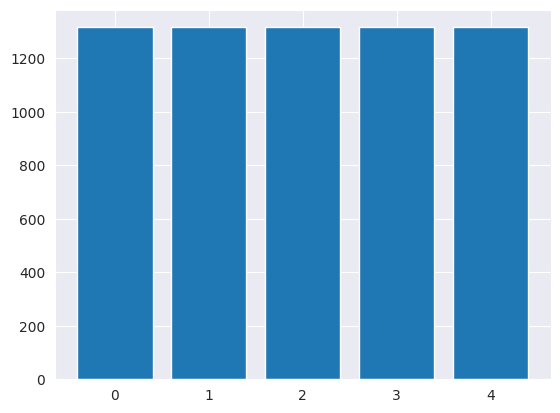

In [121]:
plt.bar(x = y_resampled.unique(), height = y_resampled.value_counts())

In [159]:
# train a regularized random forrest!
# rf = RandomForestClassifier(n_estimators= 200, random_state=42, min_samples_leaf=12, min_samples_split=7)پ
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_resampled, y_resampled)

SVC()

In [164]:
y_pred = clf.predict(df_test)

In [162]:
classification_results(y_true=y_resampled, y_pred=clf.predict(X_resampled), phase='Train')

 Classification Report Train:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1316
           1       0.72      0.72      0.72      1316
           2       0.94      0.78      0.85      1316
           3       0.79      0.78      0.78      1316
           4       0.86      0.94      0.90      1316

    accuracy                           0.81      6580
   macro avg       0.82      0.81      0.81      6580
weighted avg       0.82      0.81      0.81      6580



In [165]:
classification_results(y_true=y_test, y_pred=y_pred, phase='Test')

 Classification Report Test:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64        85
           1       0.59      0.65      0.62       127
           2       0.93      0.80      0.86       146
           3       0.61      0.53      0.57       101
           4       0.37      0.53      0.43        34

    accuracy                           0.66       493
   macro avg       0.62      0.63      0.62       493
weighted avg       0.68      0.66      0.67       493



we tested the SMOTE balancing technique to balance the classes, then we pruned the tree by setting hyper parameters of the RF classifier, but the result is not satisfying yet! we may explore more models to see if we can see better results.

the balanced SVM is more better than the Randomforrest.

# CatBoost model

In [86]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    loss_function='MultiClass',
    verbose=100
)

# Step 5: Train the model
model.fit(df_train, y_train)

0:	learn: 1.5536691	total: 1.09s	remaining: 5m 25s
100:	learn: 0.7448913	total: 59s	remaining: 1m 56s
200:	learn: 0.5227414	total: 2m	remaining: 59.5s
299:	learn: 0.3936458	total: 2m 55s	remaining: 0us


In [88]:
# Step 6: Make predictions
y_pred = model.predict(df_test)

In [89]:
classification_results(y_true=y_train, y_pred=model.predict(df_train), phase='Train')

 Classification Report Train:
              precision    recall  f1-score   support

       ANGRY       0.95      0.96      0.96       911
        FEAR       0.99      0.92      0.95       308
       HAPPY       0.98      0.96      0.97      1316
       OTHER       0.95      0.97      0.96      1136
         SAD       0.94      0.95      0.95       760

    accuracy                           0.96      4431
   macro avg       0.96      0.95      0.96      4431
weighted avg       0.96      0.96      0.96      4431



In [90]:
classification_results(y_true=y_test, y_pred=y_pred, phase='Test')

 Classification Report Test:
              precision    recall  f1-score   support

       ANGRY       0.63      0.54      0.59       101
        FEAR       0.44      0.35      0.39        34
       HAPPY       0.81      0.79      0.80       146
       OTHER       0.54      0.65      0.59       127
         SAD       0.56      0.54      0.55        85

    accuracy                           0.63       493
   macro avg       0.60      0.58      0.58       493
weighted avg       0.64      0.63      0.63       493



Even catboost could not reach the 70%, iam about to get crazy!!

# XG boost

In [99]:
train_data = xgb.DMatrix(data=df_train, label=y_train)
test_data = xgb.DMatrix(data=df_test, label=y_test)

In [112]:
# Define parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 5,  # Number of classes in the dataset
    'learning_rate': 0.1,
}

# Train the model
model = xgb.train(params=params, dtrain=train_data, num_boost_round=50)

In [113]:
# Predict on test set
y_pred = model.predict(test_data)

In [114]:
classification_results(y_true=y_train, y_pred=model.predict(train_data), phase='Train')

 Classification Report Train:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       760
           1       0.98      0.99      0.99      1136
           2       1.00      0.98      0.99      1316
           3       0.98      0.99      0.99       911
           4       0.99      0.98      0.99       308

    accuracy                           0.99      4431
   macro avg       0.99      0.99      0.99      4431
weighted avg       0.99      0.99      0.99      4431



In [115]:
classification_results(y_true=y_test, y_pred=y_pred, phase='Test')

 Classification Report Test:
              precision    recall  f1-score   support

           0       0.54      0.48      0.51        85
           1       0.48      0.65      0.55       127
           2       0.80      0.79      0.79       146
           3       0.54      0.47      0.50       101
           4       0.38      0.18      0.24        34

    accuracy                           0.59       493
   macro avg       0.55      0.51      0.52       493
weighted avg       0.59      0.59      0.58       493



# Stacking classifiers

In [ ]:
# Initialize the base classifiers
clf1 = DecisionTreeClassifier(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)

# Initialize the StackingClassifier with the base classifiers
stacking_clf = StackingClassifier(
    estimators=[
        ('dt', clf1),
        ('rf', clf2),
        ('gb', clf3)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_clf.fit(x_train_w2v, y_train)

y_pred = stacking_clf.predict(x_test_w2v)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Stacking Classifier: {accuracy:.2f}')

Accuracy of the Stacking Classifier: 0.56


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# test MLP classifier

In [ ]:
# from sklearn.neural_network import MLPClassifier

In [ ]:
# clf = MLPClassifier(hidden_layer_sizes=(128), solver = 'sgd', verbose = 100, max_iter = 100, learning_rate_init=0.01)

In [ ]:
# clf.fit(x_train_w2v, y_train)

In [ ]:
# y_pred = clf.predict(x_test_w2v)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy of the Stacking Classifier: {accuracy:.2f}')

Accuracy of the Stacking Classifier: 0.54


## Saving fasttext model to drive

In [87]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
# # Example file paths in Colab
# colab_file_path = '/content/fasttext_model.zip'

# # Destination path in Google Drive
# drive_destination_path = '/content/drive/My Drive/fasttext_model.zip'

In [95]:
# import shutil

# # Copy file from Colab to Google Drive
# shutil.copyfile(colab_file_path, drive_destination_path)

# print(f"File copied to Google Drive: {drive_destination_path}")

File copied to Google Drive: /content/drive/My Drive/fasttext_model.zip


# unlabled data

In [207]:
data = pd.read_csv('/content/3rdHW_test.csv', header=None)

In [208]:
test_data = data[0]

In [209]:
test_data = test_data.apply(preprocess_text_1)

test_data = test_data.apply(remove_non_persian)

test_data = preprocess_series(test_data)
print('Preprocessing for test done.')

tokenized_tweets_test = [word_tokenize(tweet) for tweet in test_data]

df_test = np.array([get_embedding_vector(tweet) for tweet in tokenized_tweets_test])

Preprocessing for test done.


In [210]:
svc = svm.SVC(kernel = 'rbf')
svc.fit(df_train, y_train)

SVC()

In [211]:
accuracy_score(y_train, svc.predict(df_train))

0.7379823967501693

In [212]:
y_pred= svc.predict(df_test)

In [214]:
maping = {0:'SAD', 1:'OTHER', 2:'HAPPY',3: 'ANGRY', 4:'FEAR'}

In [217]:
y_pred = pd.Series(y_pred).map(maping)

In [220]:
data['Y'] = y_pred

In [222]:
data.columns = ['X', 'Y']

In [224]:
data.to_csv('output.csv')